<a href="https://colab.research.google.com/github/SarveswaranAbinash/ML_Tutorial/blob/main/COMP3010_Tutorial04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP3010 - Machine Learning**

The tutorial contains two parts: (theoretical) discussion and (practical) coding. The discussion part consists of important concepts, advanced topics, or open-ended questions, for which we want an in-depth discussion. The coding part contains programming exercises for you to gain hands on experience.

## **Tutorial 04**
Learning outcomes:

*   Implement and apply decision trees
*   Implement cross-validation for hyperparameter tuning
*   Apply ensemble tree methods, such as Random Forests


## An example tree

In [1]:
from graphviz import Digraph

styles = {
    'top': {'shape': 'ellipse', 'style': 'filled', 'color': 'lightblue'},
    'no':  {'shape': 'circle', 'style': 'filled', 'color': 'red'},
    'yes': {'shape': 'circle', 'style': 'filled', 'color': 'lightgreen'},
    'qst': {'shape': 'rect'}
}

example_tree = Digraph()

example_tree.node('top', 'Should I attend the ML lecture?', styles['top'])
example_tree.node('q1', 'Do I fulfill requirements?', styles['qst'])

example_tree.node('q2', 'Do I like CS?', styles['qst'])
example_tree.node('no1', 'No ', styles['no'])

example_tree.node('q3', 'Is the lecture early in the morning?', styles['qst'])
example_tree.node('no2', 'No ', styles['no'])

example_tree.node('no3', 'No ', styles['no'])
example_tree.node('yes', 'Yes', styles['yes'])

example_tree.edge('top', 'q1')

example_tree.edge('q1', 'q2', 'Yes')
example_tree.edge('q1', 'no1', 'No')

example_tree.edge('q2', 'q3', 'Yes')
example_tree.edge('q2', 'no2', 'No')

example_tree.edge('q3', 'no3', 'Yes')
example_tree.edge('q3', 'yes', 'No')

example_tree

AssertionError: 

## **Discussion**


1.   Describe how a decision tree is built.

2.   Compare and contrast decision tree classifers with kNN classifiers.

3.   How can pruning be used to address overfitting in decision trees? Explain the difference between pre-pruning and post-pruning.

4.   How would you approach the task of selecting between a single decision tree, random forest, and GBDT for a given problem.

5.   Compare the bias-variance tradeoff in various machine learning algorithms (e.g., K-Nearest Neighbors, SVM, Decision Trees, Neural Networks). Which algorithms are typically high bias and low variance and vice versa?

1. **Building a Decision Tree**:
   - Decision trees are built recursively from top to bottom.
   - At each step, the algorithm selects the best feature to split the data based on certain criteria (e.g., Gini impurity, information gain).
   - The dataset is split into subsets based on the chosen feature.
   - The process continues recursively on each subset until a stopping criterion is met (e.g., maximum depth reached, minimum number of samples per leaf).
   - Finally, each leaf node is assigned a class label or a probability distribution based on the majority class of the instances it contains.

2. **Comparison between Decision Tree Classifiers and kNN Classifiers**:
   - Decision Tree:
     - Pros: Easy to interpret, handle both numerical and categorical data, implicitly perform feature selection, can handle irrelevant features.
     - Cons: Prone to overfitting, sensitive to small variations in data.
   - kNN (k-Nearest Neighbors):
     - Pros: Simple to understand and implement, naturally handles multi-class cases, robust to noisy training data.
     - Cons: Computationally expensive during testing (requires storing all training data), sensitive to irrelevant features and the choice of distance metric.

3. **Pruning to Address Overfitting in Decision Trees**:
   - Pruning is a technique used to reduce the size of a decision tree by removing parts of the tree that do not provide significant predictive power.
   - Pre-pruning involves setting constraints on the tree-building process itself, such as limiting the maximum depth of the tree or the minimum number of samples required to split a node.
   - Post-pruning, also known as subtree replacement or cost-complexity pruning, involves growing the tree to its maximum size and then removing nodes that do not improve performance on a validation set.

4. **Selecting Between Decision Tree, Random Forest, and GBDT**:
   - Decision Tree: Suitable for simple problems, easy to interpret, prone to overfitting.
   - Random Forest: Provides better generalization by aggregating multiple decision trees, less prone to overfitting, handles high-dimensional data well.
   - Gradient Boosted Decision Trees (GBDT): Often provides better predictive performance than random forests, sensitive to hyperparameters, computationally expensive to train.

5. **Bias-Variance Tradeoff in Various Machine Learning Algorithms**:
   - K-Nearest Neighbors: Low bias, high variance.
   - Support Vector Machines (SVM): Low bias, moderate variance.
   - Decision Trees: Low bias, high variance (unless pruned).
   - Neural Networks: Low bias, high variance (depends on architecture and regularization).
   
   Generally, simpler models like linear regression have high bias but low variance, while complex models like neural networks and decision trees tend to have low bias but high variance. SVMs strike a balance between bias and variance by finding the optimal margin separating hyperplane. Regularization techniques can be used to control bias-variance tradeoff in various algorithms.

## **Coding**


In this part, you will implement logsitic regression and SVM for a classification problem.

Part 2 is adapted from [Machine Learning Specialisation](https://github.com/greyhatguy007/Machine-Learning-Specialization-Coursera) by Andrew Ng.

Part 3 is adapted from [Scikit-learn: SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).


## Outline
- [ 1 - Information theory recap ](#1)
- [ 2 - Build a decision tree (ID3) step-by-step ](#2)
  - [ 2.1 - Exercise01: Select the first attribute to split](#2.1)
  - [ 2.2 - Split the first attribute](#2.2)
  - [ 2.3 - Split the next branch](#2.3)
  - [ 2.4 - Summary](#2.4)
- [ 3 - Ensemble learning](#3)
  - [3.1 - Decision tree with varing depths](#3.1)
  - [3.2 - Exercise02: Random forest with varing depths](#3.2)
- [ 4 - Hyper-parameter tuning by cross-validation](#4)
  - [4.1 Exercise03: hyperparameter tuning](#4.1)


<a name="1"></a>
## 1 - Information theorey recap

First, let's review the concept of information theorey, especially the information gain.
* Let $T$ be the set of training samples with $n$ possible outcomes, thus $T = \{T_1, T_2, ..., T_n\}$

* The entropy is given by <p align="center"><br>$H(T) = -\sum\limits_{i=1}^N p_i\cdot\log(p_i) = -\sum\limits_{i=1}^N \frac{|T_i|}{|T|}\cdot\log(\frac{|T_i|}{|T|})$</p><br>
    
* We can also calulate the entropy after $T$ was partitioned in $T_i$ with respect to some feature $X$ <p align="center"><br>$H(T, X) = \sum\limits_{i=1}^N p_i\cdot H(T_i)$</p>

* And the information gain is defined as <p align="center"><br>$IG(X) = H(T) - H(T, X)$</p>



1.1 - Toy example

Let's go through a toy example step by step. Consider a toy dataset with
*   9 examples,
*   3 features X1, X2, X3,
*   2 classes C01, C02

```
   X1  ||  A  |  A  |  A  |  B  |  B  |  C  |  C  |  C  |  C  |
---------------------------------------------------------------
   X2  ||  0  |  0  |  1  |  1  |  0  |  1  |  1  |  1  |  0  |
---------------------------------------------------------------
   X3  || RED | GRN | GRN | BLU | RED | GRN | BLU | RED | GRN |
===============================================================
 Class || C01 | C01 | C02 | C02 | C02 | C02 | C01 | C01 | C02 |
```

* The *root* entropy

    * We have 9 samples: 4 belong to class C01 and 5 to C02 <p align="center"><br>$H(T) = -\frac{4}{9}\log(\frac{4}{9}) - \frac{5}{9}\log(\frac{5}{9}) = 0.99$</p><br>
    
* Now lets consider feature X1, which splits data into subsets $T_1$, $T_2$, and $T_3$ (with X1 value A, B, and C, respectively)<br><br>

    * Within $T_1$ there are 3 samples: 2 from C01 and 1 from C02 <p align="center"><br>$H(T_1) = -\frac{2}{3}\log(\frac{2}{3}) - \frac{1}{3}\log(\frac{1}{3}) = 0.92$</p><br>
    
    * Within $T_2$ there are 2 samples: 0 from C01 and 2 from C02 <p align="center"><br>$H(T_2) = -\frac{2}{2}\log(\frac{2}{2}) - \frac{0}{2}\log(\frac{0}{2}) = 0.00$</p><br>
    
    * Within $T_3$ there are 4 samples: 2 from C01 and 2 from C02 <p align="center"><br>$H(T_3) = -\frac{2}{4}\log(\frac{2}{4}) - \frac{2}{4}\log(\frac{2}{4}) = 1.00$</p><br>
    
    * The resulting entropy is <p align="center"><br>$H(T, X1) = \frac{3}{9}\cdot H(T_1) + \frac{2}{9}\cdot H(T_2) + \frac{4}{9}\cdot H(T_3) = 0.75$</p><br>
    
    * Thus, infromation gain if the set is split according to X1 <p align="center"><br>$IG(X1) = H(T) - H(T, X1) = 0.99 - 0.75 = 0.24 \text{ Sh }$</p><br>

We write a helper fucntion to do the above computation, in which the `probs` contains the counts $T_i$ for each outcome:

In [2]:
from math import log

def entropy(*probs):
  """Calculate information entropy"""
  try:
    total = sum(probs)
    return sum([-p / total * log(p / total, 2) for p in probs])
  except:
    return 0

H_T = entropy(4, 5)
H_T1 = entropy(2, 1)
H_T2 = entropy(0, 2)
H_T3 = entropy(2, 2)
H_T_X1 = 3/9*H_T1 + 2/9*H_T2 + 4/9*H_T3
IG_X1 = H_T - H_T_X1

print("The root entropy is: ", H_T)
print("The child entropy of subset T1 is: ", H_T1)
print("The child entropy of subset T2 is: ", H_T2)
print("The child entropy of subset T3 is: ", H_T3)
print("The (weighted) average entropy after splliting according to X1 is: ", H_T_X1)
print("The information gain of splitting based on X1 is: ", IG_X1)

The root entropy is:  0.9910760598382222
The child entropy of subset T1 is:  0.9182958340544896
The child entropy of subset T2 is:  0
The child entropy of subset T3 is:  1.0
The (weighted) average entropy after splliting according to X1 is:  0.7505430557959409
The information gain of splitting based on X1 is:  0.24053300404228128


<a name="2"></a>
## 2 - Build a decision tree (ID3) step-by-step

In this part, we will build a decision tree based on the ID3 algorithm.  We will use the popular `Play Golf` dataset, which contains:
*   4 features:
    *   outlook: rainy, overcast, sunny
    *   temperature: cool, mid, hot
    *   humidity: normal, high
    *   windy: false, true
*   2 classes (play golf?):
    *   true
    *   false

Let's load the data first:


In [14]:
import pandas as pd

# first row = headers
src = "https://gist.github.com/kudaliar032/b8cf65d84b73903257ed603f6c1a2508/raw/aa4826eb745d09a2df4967a793410e141642cbed/golf-dataset.csv"

golf_data = pd.read_csv(src)
golf_data


,Outlook,Temp,Humidity,Windy,Play Golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


<a name="2.1"></a>
### 2.1 Exercise1 - Select the first attribute to split

Starting from an empty tree, the first step is to select the first attribute to split, and the criteria is to maximise the information gain. Therefore, we need to compute 1) the root entropy; 2) for each feature, compute resulting entropy after splitting and the difference with 1; 3) find the feature that gives the largest information gain:

In [20]:
import numpy as np

# Define a function to compute entropy
def entropy(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Assume golf_data is defined

# Root Entropy (H_T)
root_entropy = entropy(golf_data['Play Golf'])

# Compute entropies and information gains for each feature
# Outlook
outlook_entropy = golf_data.groupby('Outlook').apply(lambda x: entropy(x['Play Golf']) * len(x) / len(golf_data)).sum()
IG_outlook = root_entropy - outlook_entropy

# Temperature
temp_entropy = golf_data.groupby('Temp').apply(lambda x: entropy(x['Play Golf']) * len(x) / len(golf_data)).sum()
IG_temp = root_entropy - temp_entropy

# Humidity
humidity_entropy = golf_data.groupby('Humidity').apply(lambda x: entropy(x['Play Golf']) * len(x) / len(golf_data)).sum()
IG_humidity = root_entropy - humidity_entropy

# Windy
windy_entropy = golf_data.groupby('Windy').apply(lambda x: entropy(x['Play Golf']) * len(x) / len(golf_data)).sum()
IG_windy = root_entropy - windy_entropy

# Identify the feature with the largest information gain
largest_IG = max(IG_outlook, IG_temp, IG_humidity, IG_windy)
if largest_IG == IG_outlook:
    feature_with_largest_IG = 'Outlook'
elif largest_IG == IG_temp:
    feature_with_largest_IG = 'Temperature'
elif largest_IG == IG_humidity:
    feature_with_largest_IG = 'Humidity'
else:
    feature_with_largest_IG = 'Windy'

# Print results
print(f"The root entropy H(T) = {root_entropy:.2f}")
print(f"The information gain (IG) for Outlook IG(outlook) = {IG_outlook:.2f}")
print(f"The IG for Temperature IG(temp) = {IG_temp:.2f}")
print(f"The IG for Humidity IG(humi) = {IG_humidity:.2f}")
print(f"The IG for Windy IG(windy) = {IG_windy:.2f}")
print(f"The feature with the largest IG is: {feature_with_largest_IG}")


The root entropy H(T) = 0.94
The information gain (IG) for Outlook IG(outlook) = 0.25
The IG for Temperature IG(temp) = 0.03
The IG for Humidity IG(humi) = 0.15
The IG for Windy IG(windy) = 0.05
The feature with the largest IG is: Outlook


**Expected Output**:
<table>
  <tr>
    <td> <b>The root entropy H(T)= 0.94<b></td>
  </tr>
  <tr>
    <td> <b>The information gain (IG) for outlook IG(outlook)= 0.25<b></td>
  </tr>
  <tr>
    <td> <b>The IG for temperature IG(temp)= 0.03<b></td>
  </tr>
    <tr>
    <td> <b>The IG for humidity IG(humi)= 0.15<b></td>
  </tr>
      <tr>
    <td> <b>The IG for windy IG(humi)= 0.05<b></td>
  </tr>
</table>

<a name="2.2"></a>
### 2.2 Split the first attribute

`Outlook` has the largest information gain and thus we split based on this feature. Note that a branch with __zero entropy__ is a leaf node: overcast.

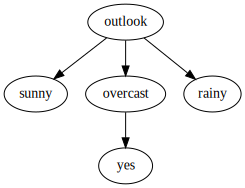

In [5]:
tree = Digraph()

tree.edge("outlook", "sunny")
tree.edge("outlook", "overcast")
tree.edge("outlook", "rainy")

tree.edge("overcast", "yes")

tree

<a name="2.3"></a>
### 2.3 Split the next branch

After that, we need to split the next branch. Following the left-to-right convention, it means ``outlook=sunny``. Let's first filter out this subset of data examples:

In [21]:
golf_data.loc[golf_data['Outlook'] == "Sunny"]

,Outlook,Temp,Humidity,Windy,Play Golf
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
9,Sunny,Mild,Normal,False,Yes
13,Sunny,Mild,High,True,No


We will then recursively find the "best" feature to split based on the information gain. We will skip the calculation for now, and in this case, you will find ``windy`` has the largest information gain, which will be taken for this split:

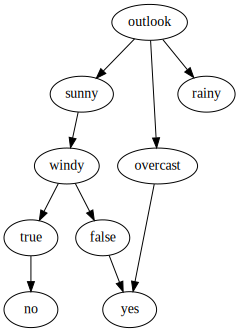

In [22]:
tree.edge("sunny", "windy")

tree.edge("windy", "false")
tree.edge("windy", "true")

tree.edge("false", "yes")
tree.edge("true", "no")

tree

Following this, we will split the last branch ``outlook==rainy``:

In [23]:
golf_data.loc[golf_data['Outlook'] == "Rainy"]

,Outlook,Temp,Humidity,Windy,Play Golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
10,Rainy,Mild,Normal,True,Yes


In this case, ``humidity`` will has the largest information gain ( as can be seen from its correspondence with the target ``play golf``). Therefore, ``humidity`` is used for split ater ``rainy``:

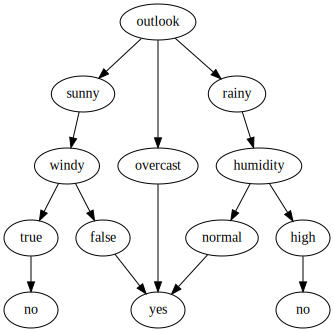

In [24]:
tree.edge("rainy", "humidity")

tree.edge("humidity", "high")
tree.edge("humidity", "normal")

tree.edge("normal", "yes")
tree.edge("high", "no ")

tree

<a name="2.4"></a>
### 2.4 Summary

Congradulations! You have just built the entire decision tree for the Play Golf dataset using ID3 algorithm. Several notes:
*   Note that we didn't even end up with using the temperature attribute. Why?
*   The main problem with ID3 is overfitting as the tree doesn't stop growing until the whole training set is classified. Need prunning!
*   There is a bias towards features with many possible outcomes. Why?
*   There are other tree construction methods, e.g., C4.5, CART, which improves ID3 with additional techniques, such as information gain normalization, prunning, etc.

<a name="3"></a>
## 3 - Ensemble Learning

In this exercise, we will conduct ensemble learning, in particular, ensembled tree methods, using scikit-learn (Hoo...ray!). We will show that a single decision tree can easily overfit a given dataset with enough tree depth, while the Random forest algorithm mitigates the problem with bagging.

Let's first generate data by making blobs:

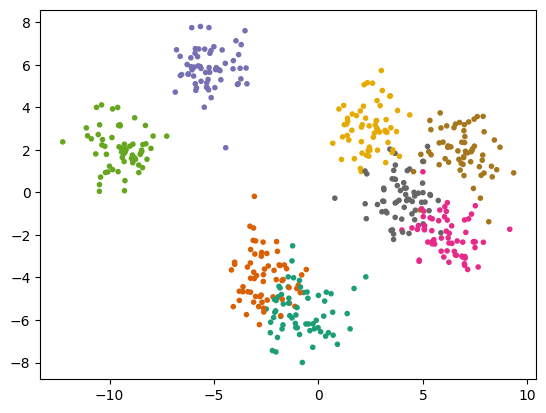

In [25]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# generate 5 blobs with fixed random generator
X, Y = make_blobs(n_samples=500, centers=8, random_state=300)

plt.scatter(*X.T, c=Y, marker='.', cmap='Dark2')

To make our life easier we create a helper function to:
* plot training data on existing axes or new one (if not provided)

* train given classifier on given dataset

* create countours representing predictions of the classifier

In [26]:
def train_and_look(classifier, X, Y, ax=None, title='', cmap='Dark2'):
  """Train classifier on (X,Y). Plot data and prediction."""
  # create new axis if not provided
  ax = ax or plt.gca();

  ax.set_title(title)

  # plot training data
  ax.scatter(*X.T, c=Y, marker='.', cmap=cmap)

  # train a cliassifier
  classifier.fit(X, Y)

  # create a grid of testing points
  x_, y_ = np.meshgrid(np.linspace(*ax.get_xlim(), num=200),
                       np.linspace(*ax.get_ylim(), num=200))

  # convert to an array of 2D points
  test_data = np.vstack([x_.ravel(), y_.ravel()]).T

  # make a prediction and reshape to grid structure
  z_ = classifier.predict(test_data).reshape(x_.shape)

  # arange z bins so class labels are in the middle
  z_levels = np.arange(len(np.unique(Y)) + 1) - 0.5

  # plot contours corresponding to classifier prediction
  ax.contourf(x_, y_, z_, alpha=0.25, cmap=cmap, levels=z_levels)

Let's check how it works on a decision tree classifier with default settings from sklearn:

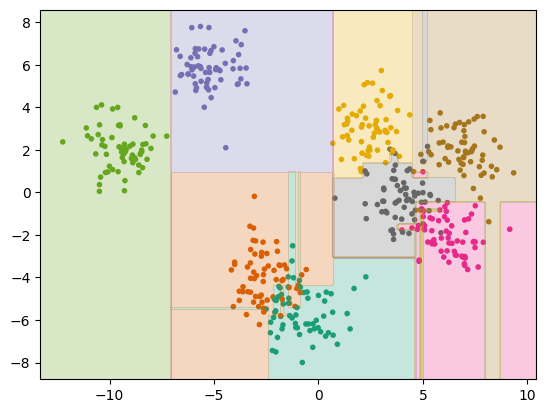

In [27]:
from sklearn.tree import DecisionTreeClassifier as DT

train_and_look(DT(), X, Y)

Note that sklearn also provided a function [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) to visualize the decision tree.

<a name="3.1"></a>
### 3.1 - Decision tree with varing depths

Now we're ready to do some real business. We will consider decision trees of varing capacity by changing one of the important hyperparameter maximum depths from 1 to 9, and see how they classify the blob dataset:

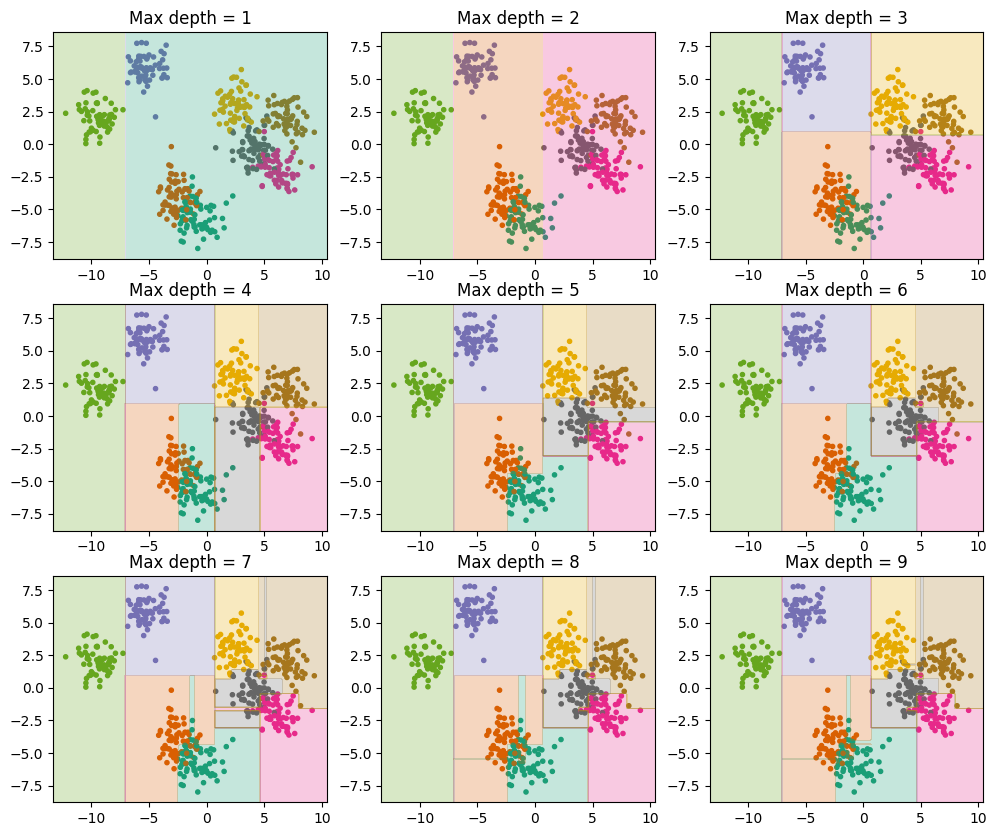

In [28]:
# create a figure with 9 axes 3x3
fig, ax = plt.subplots(3, 3, figsize=(12,10))

# train and look at decision trees with different max depth
for max_depth in range(0, 9):
  train_and_look(DT(max_depth=max_depth + 1), X, Y,
                 ax=ax[max_depth // 3][max_depth % 3],
                 title="Max depth = {}".format(max_depth + 1))

What do you see?


*   ``max_depth`` <= 3  -> undefitting
*   4 <=``max_depth`` <= 6  -> fit well
*   ``max_depth`` > 6  ->  overfitting

<a name="3.2"></a>
### 3.2 - Exercise02: Random forest with varing depths

Let's do the same with random forests. Please check the [random forests doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

What do you see this time?


*   The combination of shallow trees does a good job
*   Overfitting of deep tree is somewhat prevented



<a name="4"></a>
## 4 - Hyper-parameter tuning by cross-validation

We already know that decision tree can easily overfit data, because without any stopping criterion the tree is growing until there is a sinple point in a leaf (for numerical features). One technique is to use __pre-prunning or early stopping__ by setting up:

*   a max depth
*   a min number of examples in a leaf
*   a min information gain
*   ...

These are all ``hyperparameters`` of decision trees. How do we know what values to use for these hyperparameters? -- use validation set. Here we will go through one validation technique called cross-validation.

Again, to make it easiler, we have prepared a helper class to do the following:


*   It takes training data and hyperparameter name (as named in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier))
*   It can change hyperparameter
*   It can perform a cross-validation for a set of hyperparameter values
*   It can make accuracy and best fit plots





In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

class TreeCV:
  """Perform a cross-validation for chosen hyperparameter"""

  def __init__(self, X, Y, hp="max_depth"):
    """Save training data"""
    self.X = X    # features
    self.Y = Y    # targets
    self.hp = hp  # hyperparameter


  def set_method(self, hp):
    """Set hyperparameter to use"""
    self.hp = hp


  def cross_me(self, *hp_vals):
    """Perform cross validation for given hyperparameter values"""
    self.scores = []  # the accuracy table
    self.best = None  # the best fit

    best_score = 0

    for hp in hp_vals:
      # create a tree with given hyperparameter cut
      fit = DecisionTreeRegressor(**{self.hp: hp})

      # calculate a cross validation scores and a mean value
      score = cross_val_score(fit, np.reshape(X, (-1, 1)), Y).mean()

      # update best fit if necessary
      if score > best_score:
        self.best = fit
        best_score = score

      self.scores.append([hp, score])

    # train the best fit
    self.best.fit(np.reshape(X, (-1, 1)), Y)


  def plot(self):
    """Plot accuracy as a function of hyperparameter values and best fit"""
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)

    plt.xlabel(self.hp)
    plt.ylabel("accuracy")

    plt.plot(*zip(*self.scores))

    plt.subplot(1, 2, 2)

    X_test = np.arange(0.0, 1.0, 0.01)[:, np.newaxis]
    Y_test = self.best.predict(X_test)

    plt.scatter(self.X, self.Y, color='b', marker='.', label="Training data")
    plt.plot(X_test, X_test * X_test, 'g', label="True distribution")
    plt.plot(X_test, Y_test, 'r', label="Decision tree")

    plt.legend()

*Let*'s generate some data

In [30]:
X = np.random.sample(200)
Y = np.array([x**2 + np.random.normal(0, 0.05) for x in X])

And let's try to tune the hyperparameter ``max_depth``:

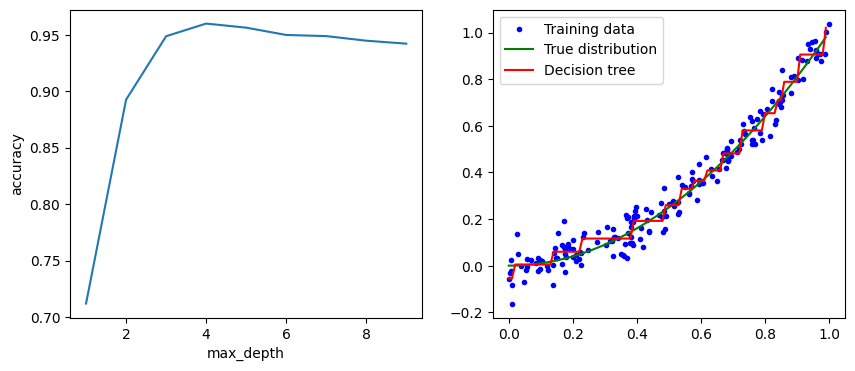

In [31]:
tree_handler = TreeCV(X, Y)
tree_handler.cross_me(*range(1, 10))
tree_handler.plot()

As seen, we have examined the ``max_depth`` from 1 to 9, and the cross validation process indicates that ``max_depth==4`` might be a good choice. The plot on the right verifies it.

<a name="4.1"></a>
### 4.1 - Exercise03: hyperparameter tunning

Following the above process, you can try to tune other hyperparameters using cross validation, such as


*   ``min_samples_leaf``
*   ``min_samples_split``
*   ``min_impurity_decrease``



You can find a list of hyperparameters from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree).

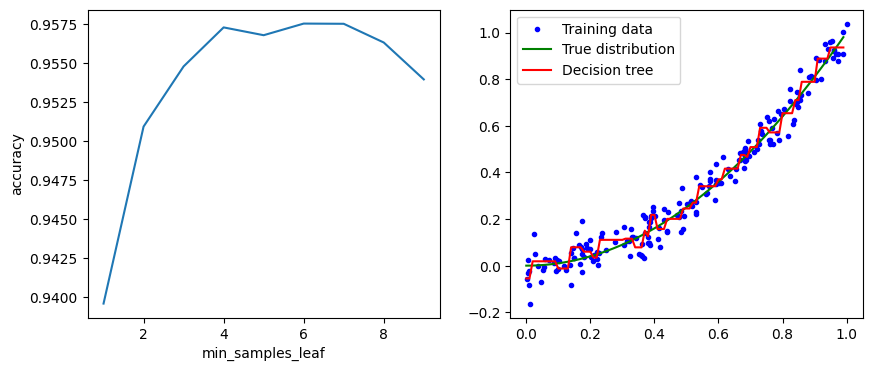

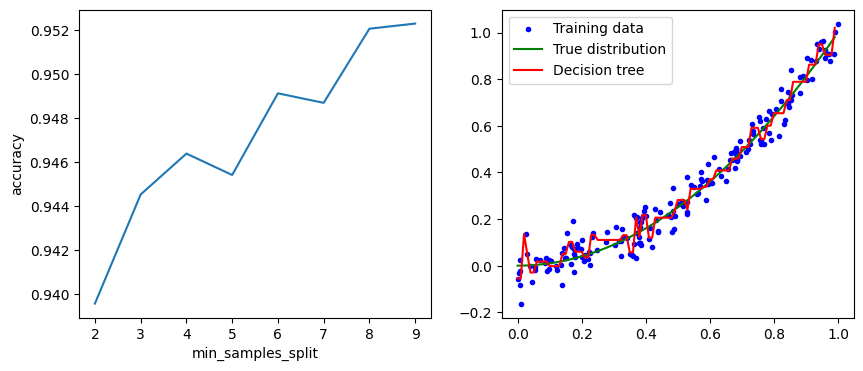

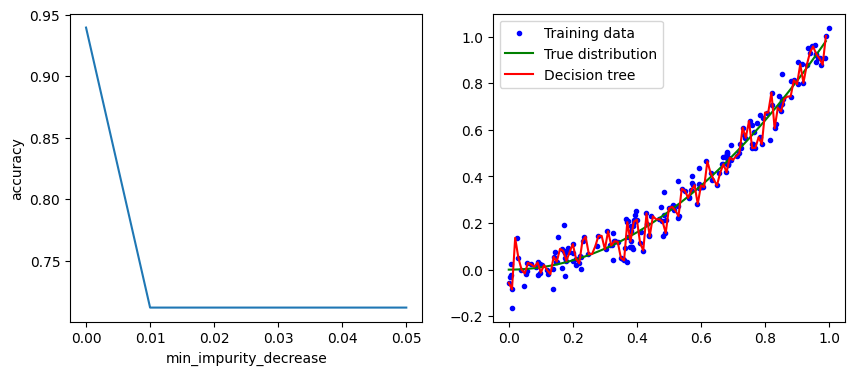

In [32]:
# For min_samples_leaf
tree_handler_min_samples_leaf = TreeCV(X, Y, hp="min_samples_leaf")
tree_handler_min_samples_leaf.cross_me(*range(1, 10))
tree_handler_min_samples_leaf.plot()

# For min_samples_split
tree_handler_min_samples_split = TreeCV(X, Y, hp="min_samples_split")
tree_handler_min_samples_split.cross_me(*range(2, 10))
tree_handler_min_samples_split.plot()

# For min_impurity_decrease
tree_handler_min_impurity_decrease = TreeCV(X, Y, hp="min_impurity_decrease")
tree_handler_min_impurity_decrease.cross_me(0.0, 0.01, 0.02, 0.03, 0.04, 0.05)
tree_handler_min_impurity_decrease.plot()


That's all. Well done!